In [2]:
import numpy as np
from scipy import ndimage, fftpack, stats
import scipy
import cv2
from skimage.morphology import disk, binary_dilation, binary_erosion, binary_closing
from skimage.filters import threshold_otsu, gaussian
from PIL import Image
from skimage.filters import threshold_multiotsu
import pywt

def new_image_open_generator(old_open=Image.open):
    Image.old_open = old_open  # Save the original open function for later use

    def new_image_open(path, *args, **kwargs):
        path = str(path)
        if path.endswith(".npy"):
            arr = np.load(path, allow_pickle=False)
            if arr.dtype == np.uint8:
                return Image.fromarray(arr)
            elif arr.dtype == np.uint16:
                return Image.fromarray(arr, mode="I;16")
            else:
                raise ValueError(f"Unsupported dtype: {arr.dtype}")
        return Image.old_open(path, *args, **kwargs)

    return new_image_open


Image.open = new_image_open_generator(Image.open)


def block_view(A, block_shape):
    shape = (A.shape[0] // block_shape[0], A.shape[1] // block_shape[1]) + block_shape
    strides = (block_shape[0] * A.strides[0], block_shape[1] * A.strides[1]) + A.strides
    return np.lib.stride_tricks.as_strided(A, shape=shape, strides=strides)


def calculate_snr(image, patch_size):
    blocks = block_view(image, (patch_size, patch_size))
    # Flatten the blocks to calculate the mean and std efficiently
    flattened_blocks = blocks.reshape(-1, patch_size, patch_size)
    means = np.mean(flattened_blocks, axis=(1, 2))
    stds = np.std(flattened_blocks, axis=(1, 2)) + 1e-5  # Avoid division by zero
    # Calculate the SNR values for each block without the need for a loop
    snr_values = means / stds
    # Reshape the SNR values to match the blocked image shape
    snr_map = snr_values.reshape(blocks.shape[0], blocks.shape[1])
    return snr_map


def smooth_snr_map(snr_map, kernel_size):
    kernel = np.ones((kernel_size, kernel_size)) / (kernel_size**2)
    smoothed_snr_map = scipy.ndimage.convolve(snr_map, kernel, mode="constant", cval=0.0)
    return smoothed_snr_map


def gen_mask(image, threshold):
    mask = np.zeros_like(image)
    mask[image > threshold] = 1
    return mask


def expand_mask(mask, patch_size):
    expanded_mask = np.kron(mask, np.ones((patch_size, patch_size)))
    return expanded_mask


def high_pass(img, r=5):
    fft = fftpack.fft2(img)
    fft_shift = fftpack.fftshift(fft)
    
    rows, cols = img.shape
    crow, ccol = rows//2, cols//2
    mask = np.ones((rows, cols))
    y, x = np.ogrid[-crow:rows-crow, -ccol:cols-ccol]
    mask_area = x*x + y*y <= r*r
    mask[mask_area] = 0
    
    # Make sure mask is symmetric
    mask = np.fft.fftshift(mask)
    
    fft_filtered = fft * mask  # Apply mask without shifting
    img_filtered = np.real(fftpack.ifft2(fft_filtered))
    return img_filtered

def std_norm(img, new_std=1):
    img = img.astype(np.float32)
    mean, std = np.mean(img), np.std(img)
    if std == 0:
        return img
    return (img - mean) * (new_std/std) + new_std

def min_max_norm(img, min=0, max=1):
    img = img.astype(np.float32)
    if img.max() == 0:
        return img
    return np.clip((img - img.min()) * (max - min)/(img.max() - img.min()) + min, min, max)

def max_norm(img):
    img = img.astype(np.float32)
    if img.max() == 0:
        return img
    return np.clip(img / img.max(), 0, 1)

def mean_std(img):
    return np.mean(img), np.std(img)

def mean_threshold(img, devs=5):
    img = img.astype(np.float32)
    mean, std = mean_std(img)
    img[img > mean + devs * std] = 0
    return img

def otsu_mask(img):
    threshold = threshold_otsu(img)
    return img > threshold

def process_image(image, patch_size=8):
    image = np.array(image)
    dtype = np.uint16
    dtype_max = np.iinfo(dtype).max  # Get the maximum value for the image dtype

    

    return mask

def emphasize_fluorescence(img, mask, emphasis_factor=2.0):
    result = img.copy()
    
    if np.any(mask):
        # Apply Anscombe transform - stabilizes Poisson-Gaussian variance
        # 2 * sqrt(x + 3/8)
        transformed = 2 * np.sqrt(img[mask] + 3/8)
        
        # Use robust statistics since fluorescence can have bright spots
        median = np.median(transformed)
        mad = np.median(np.abs(transformed - median)) * 1.4826  # scale factor for normal distribution
        
        # Define bounds using median absolute deviation (more robust than std)
        lower = median - 3 * mad
        upper = median + 3 * mad
        
        # Clip and rescale
        transformed = np.clip(transformed, lower, upper)
        result[mask] = ((transformed - lower) * emphasis_factor / (upper - lower)) ** 2
    
    if np.any(~mask):
        result[~mask] = result[~mask] / result[~mask].max()
        
    return result / result.max()


def analyze_horizontal_components(image: np.ndarray, wavelet: str = 'db1', level: int = 1) -> tuple:
    """
    Analyze horizontal components of an image using Daubechies wavelet transform.
    
    Args:
        image: Input image as numpy array (uint16)
        wavelet: Wavelet to use (default: 'db1')
        level: Decomposition level (default: 1)
    
    Returns:
        tuple: Coefficients and horizontal detail coefficients
    """
    # Convert to float64 for wavelet transform
    image_float = image.astype(np.float64)
    
    # Perform 2D wavelet transform
    coeffs = pywt.wavedec2(image_float, wavelet, level=level)
    
    # Get horizontal details at each level
    horizontal_details = [detail[1] for detail in coeffs[1:]]
    
    return horizontal_details


In [24]:
from matplotlib import pyplot as plt
import numpy as np
from hyperscope import config
from mpl_toolkits.axes_grid1 import make_axes_locatable



plt.figure(figsize=(15,8))

mkate_img = np.array(Image.open(config.RAW_DATA_DIR / "worms/mkate_1738433994.799984.npy")).astype(np.float32)
mkate_img = mkate_img[150:800, 20:1440]
mcherry_img = np.array(Image.open(config.RAW_DATA_DIR / "worms/mcherry_1738436808.634179.npy")).astype(np.float32)
mcherry_img = mcherry_img[150:800, 20:1440]
mkate_img = min_max_norm(mkate_img)
mcherry_img = min_max_norm(mcherry_img)
# mkate_img = np.array(mkate_img)[90:790,0:1440]
# mcherry_img = np.array(mcherry_img)[90:790,0:1440]

mkate_mask = process_image(mkate_img)
mcherry_mask = process_image(mcherry_img)
# mkate_img = emphasize_fluorescence(mkate_img, mkate_mask)
ax = plt.subplot(121)
im = ax.imshow(mkate_mask, cmap='binary')
ax.set_title('mkate mask')

ax = plt.subplot(122)
im = ax.imshow(mkate_img)
ax.set_title('mkate')

# Create divider for exact sizing
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.3)

# Add colorbar to the new axes
plt.colorbar(im, cax=cax, orientation='horizontal')

plt.tight_layout()

plt.show()

plt.figure(figsize=(15,8))
ax = plt.subplot(121)
im = ax.imshow(mcherry_mask, cmap='binary')
ax.set_title('mkate mask')

ax = plt.subplot(122)
im = ax.imshow(mcherry_img)
ax.set_title('mcherry')

# Create divider for exact sizing
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.3)

# Add colorbar to the new axes
plt.colorbar(im, cax=cax, orientation='horizontal')

plt.tight_layout()

plt.show()

NameError: name 'mask' is not defined

<Figure size 1500x800 with 0 Axes>

Vairance: 1.415460


<Figure size 1500x800 with 0 Axes>

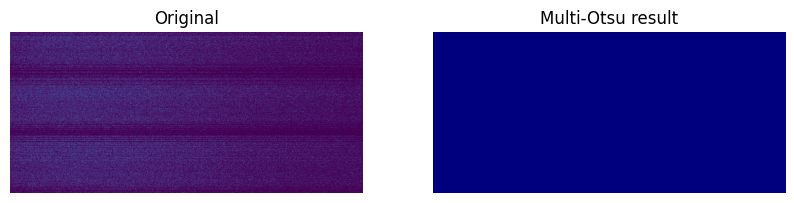

In [5]:

from skimage.filters import threshold_multiotsu
from matplotlib import pyplot as plt
import numpy as np
from hyperscope import config
import cv2
from matplotlib.colors import BoundaryNorm





clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(32, 32))

plt.figure(figsize=(15,8))
mkate_img = np.array(Image.open(config.RAW_DATA_DIR / "worms/mkate_1738434720.943984.npy")).astype(np.uint16)
mkate_img = mkate_img[150:800, 20:1440]
mcherry_img = np.array(Image.open(config.RAW_DATA_DIR / "worms/mcherry_1738436808.634179.npy")).astype(np.uint16)
mcherry_img = mcherry_img[150:800, 20:1440]

horizontal_variance = analyze_horizontal_components(mkate_img, wavelet='db4')[0].var()

mkate_img = clahe.apply(mkate_img)
mcherry_img = clahe.apply(mcherry_img)

# Applying multi-Otsu threshold for the default value, generating
# three classes.
print(f'Vairance: {horizontal_variance:2f}')
thresholds = threshold_multiotsu(mkate_img)

# Using the threshold values, we generate the three regions.
regions = np.digitize(mkate_img, bins=thresholds) if horizontal_variance >= 3 else np.zeros(np.shape(mkate_img), dtype = np.uint8)

mkate_img = cv2.normalize(
                        mkate_img, None, alpha=0, beta=int(2**16 - 1), norm_type=cv2.NORM_MINMAX
                    )

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


# Plotting the original image.
ax[0].imshow(mkate_img)
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the Multi Otsu result.
ax[1].imshow(np.vstack(regions), cmap='jet', interpolation='nearest')
ax[1].set_title('Multi-Otsu result')
ax[1].axis('off')

plt.subplots_adjust()

plt.show()

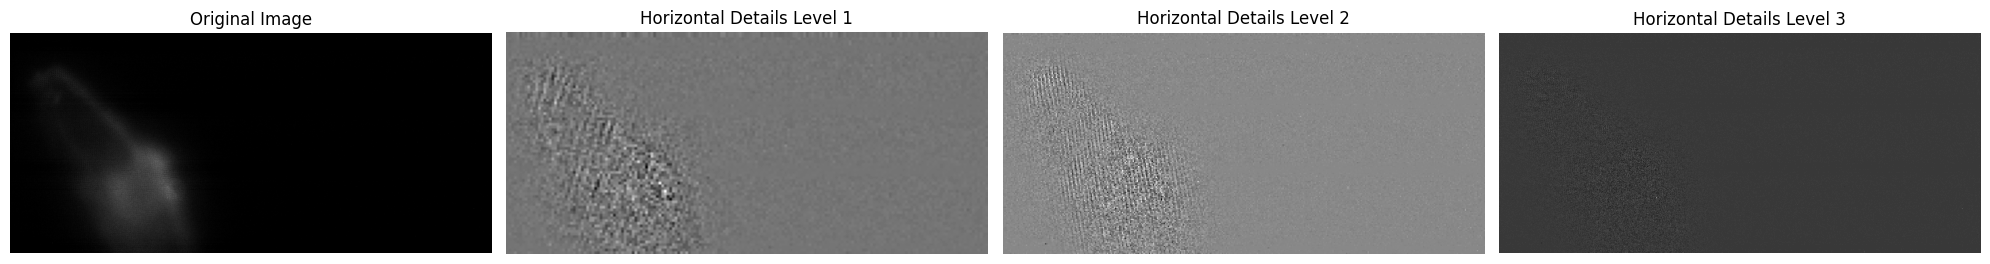

Level 1 horizontal details shape: (83, 180)
Level 1 horizontal details range: [-30.60, 36.54]
Level 1 horizontal details variance: 9.00
Level 2 horizontal details shape: (164, 357)
Level 2 horizontal details range: [-34.83, 30.49]
Level 2 horizontal details variance: 10.16
Level 3 horizontal details shape: (326, 711)
Level 3 horizontal details range: [-34.28, 117.83]
Level 3 horizontal details variance: 7.86
[array([[10.95869569, 11.18539229,  8.86013286, ...,  9.36258011,
         9.20166544,  7.95200612],
       [10.86518071, 11.06467538,  8.60318998, ...,  9.35732621,
         9.70984768,  8.22406512],
       [12.32542426, 12.28657545, 10.75166294, ...,  9.01964925,
        10.04250411, 10.69030555],
       ...,
       [ 8.10233946,  8.32394836,  8.81630117, ...,  7.76222054,
         8.12855476,  8.58551019],
       [10.01720036,  9.60936349,  8.57801322, ..., 10.05366404,
         8.29122093,  8.12914913],
       [ 8.14005469,  8.11481713,  8.08293781, ...,  8.05189804,
         8

In [27]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# mkate_img = np.array(Image.open(config.RAW_DATA_DIR / "worms/mkate_1738434720.943984.npy")).astype(np.uint16)

mkate_img = np.array(Image.open(config.RAW_DATA_DIR / "worms/mkate_1738433994.799984.npy")).astype(np.uint16)

mkate_img = mkate_img[150:800, 20:1440]

def analyze_horizontal_components(image: np.ndarray, wavelet: str = 'db1', level: int = 1) -> tuple:
    """
    Analyze horizontal components of an image using Daubechies wavelet transform.
    
    Args:
        image: Input image as numpy array (uint16)
        wavelet: Wavelet to use (default: 'db1')
        level: Decomposition level (default: 1)
    
    Returns:
        tuple: Coefficients and horizontal detail coefficients
    """
    # Convert to float64 for wavelet transform
    image_float = image.astype(np.float64)
    
    # Perform 2D wavelet transform
    coeffs = pywt.wavedec2(image_float, wavelet, level=level)
    
    # Get horizontal details at each level
    horizontal_details = [detail[1] for detail in coeffs[1:]]
    
    return coeffs, horizontal_details

# Example usage
def plot_horizontal_components(image: np.ndarray, horizontal_details: list) -> None:
    """
    Plot original image and horizontal components.
    
    Args:
        image: Original image
        horizontal_details: List of horizontal detail coefficients
    """
    # Create subplot layout
    n_plots = len(horizontal_details) + 1
    fig, axes = plt.subplots(1, n_plots, figsize=(n_plots * 5, 5))
    
    # Plot original image
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Plot horizontal details
    for i, detail in enumerate(horizontal_details, 1):
        axes[i].imshow(detail, cmap='gray')
        axes[i].set_title(f'Horizontal Details Level {i}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage with a sample image
def main():
    # Create a sample image (replace this with your actual image)
    sample_image = np.random.randint(0, 65535, size=(256, 256), dtype=np.uint16)
    
    # Analyze horizontal components
    coeffs, horizontal_details = analyze_horizontal_components(
        mkate_img,
        wavelet='db2',  # Using Daubechies-4 wavelet
        level=3         # 3 levels of decomposition
    )
    
    # Plot results
    plot_horizontal_components(mkate_img, horizontal_details)
    
    # Print some information about the horizontal components
    for i, detail in enumerate(horizontal_details, 1):
        print(f"Level {i} horizontal details shape: {detail.shape}")
        print(f"Level {i} horizontal details range: [{detail.min():.2f}, {detail.max():.2f}]")
        print(f"Level {i} horizontal details variance: {detail.var():.2f}")

    print(coeffs)
main()